## Pendulum Simulation for Multiple Non-Linear Regression Problem Generation

### Dr. Andrew Strelzoff, Dr. James Ross ERDC-ITL-Data Science

#### MIT License

Based on the terrific article by Jake VanderPlas here https://jakevdp.github.io/blog/2017/03/08/triple-pendulum-chaos/

In [1]:
#plot charts in the notebook
%matplotlib inline

#load some useful libraries
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.fftpack import fft

from IPython.display import HTML, display_html

import random

In [2]:
from sklearn.multioutput import MultiOutputRegressor

from sklearn.svm import SVR

from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor

import chocolate as choco

import pandas as pd

from chocolate import SQLiteConnection

C:\Users\rditlas8\AppData\Local\Continuum\anaconda3\envs\vrsense1\lib\site-packages\chocolate\mo\pyhv.py:16: ImportWarning: Using Python version of hypervolume module. Expect this to be slower.
  warnings.warn("Using Python version of hypervolume module. Expect this to be slower.", ImportWarning)


In [3]:
#multi-section pendulum simulation
def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1):
    """Integrate a multi-pendulum with `n` sections"""
    #-------------------------------------------------
    # Step 1: construct the pendulum model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(forces, particles)
    
    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))
        
    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))

In [4]:
#post processing function for pendulum simulation data
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

def animate_pendulum(x,y,t,lengths):  
    fig, ax = plt.subplots(figsize=(3,5),facecolor='red')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    limit=lengths.sum()
    ax.set(xlim=(-limit-1, limit+1), ylim=(-limit-1, limit+1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(t),
                                   interval=1000 * t.max() / len(t),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

## Simulate a Double Pendumum, Gather and Plot Positional Data

### Let's focus on pendulums with larger starting angle that will have more non-linear behavior

In [5]:
pendulum_type = 2

start_time = 0
end_time = 20 #time tics
sampling_rate = 10 #samples per time tic, higher=smoother, but will take longer

#linear-ish "mustache"
start=92
initial_positions=[start,start] # starting angle of each section of pendulum
masses=[3.0,2.0] #mass of each point mass at the end of it's section
lengths=np.asarray([3,1])  #length of each section

#definitely non-linear
#initial_positions=[50,150] # starting angle of each section of pendulum
#masses=[1.5,1.0] #mass of each point mass at the end of it's section
#lengths=[0.5,2]  #length of each section

bins = (end_time - start_time)*sampling_rate # array size , freq bins will be N/2
t = np.linspace(start_time, end_time, bins)
p = integrate_pendulum(n=pendulum_type, times=t,initial_positions=initial_positions,masses=masses,lengths=lengths)
x_pend, y_pend = get_xy_coords(p,lengths)

anim = animate_pendulum(x_pend,y_pend,t,lengths)

HTML(anim.to_jshtml())


D:\anaconda\envs\modelHPC\lib\site-packages\sympy\physics\mechanics\kane.py:536: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


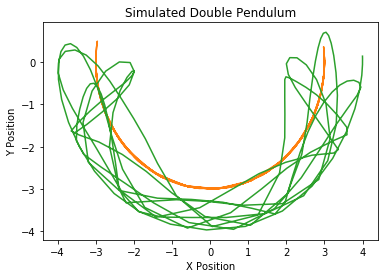

In [6]:
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Simulated Double Pendulum');
display_html(plt.plot(x_pend, y_pend))

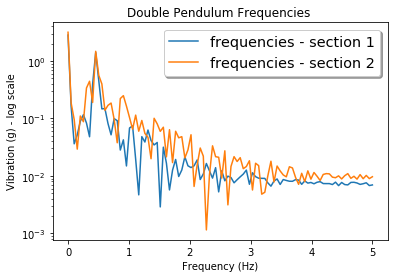

In [10]:

def estimate_frequencies(x_pos,y_pos,section,x_or_y,sampling_rate,bins):
    if x_or_y == 'x':
        direction = 0
    else:
        direction = 1
    
    # Nyquist Sampling Criteria
    T = 1/sampling_rate # inverse of the sampling rate
    frequencies = np.linspace(0.0, 1.0/(2.0*T), int(bins/2))

    # FFT algorithm
    yr = fft(y_pend[direction:bins,section]) # "raw" FFT with both + and - frequencies
    magnitudes = 2/bins * np.abs(yr[0:np.int(bins/2)]) # positive freqs only
    
    return frequencies,magnitudes
section = 1
direction = 'x'
frequencies1,magnitudes1 = estimate_frequencies(x_pend,y_pend,section=section,x_or_y=direction,sampling_rate=sampling_rate,bins=bins)
section = 2
direction = 'x'
frequencies2,magnitudes2 = estimate_frequencies(x_pend,y_pend,section=section,x_or_y=direction,sampling_rate=sampling_rate,bins=bins)

# Plotting the results
plt.plot(frequencies1, magnitudes1,label='frequencies - section 1')
plt.plot(frequencies2, magnitudes2,label='frequencies - section 2')
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g) - log scale')
plt.yscale('log')
plt.title('Double Pendulum Frequencies ' );
plt.show()



In [13]:
num =1000

dataset_X_frequencies_nl = np.empty(shape=(num,200)) #X frequencies for sections 1 (0,99) and sections 2 (100,199)
dataset_Y_frequencies_nl = np.empty(shape=(num,200)) #Y frequencies for sections 1 (0,99) and sections 2 (100,199)
temp_meta = np.empty(shape=(num,4)) #weight1,weight2,length1,length2

In [15]:
#this is a bit slow - If you have a crummy computer skip this cell and load dataset_X_frequencies.csv and dataset_Y_frequencies.csv below instead 

start_time = 0
end_time = 20 #time tics
sampling_rate = 10 #samples per time tic, higher=smoother, but will take longer

bins = (end_time - start_time)*sampling_rate # array size , freq bins will be N/2
t = np.linspace(start_time, end_time, bins)

#non-linear chaos
initial_positions=[92,92] # starting angle of each section of pendulum
#masses=[5,2.5] we're going to vary this
#lengths=[1,10] we're going to vary this

for i in range(0,num):
    temp_meta[i] = np.random.uniform(low=0.5,high=1.5,size=4)
    p = integrate_pendulum(n=2, times=t,initial_positions=initial_positions,masses=temp_meta[i,0:2],lengths=temp_meta[i,2:4])
    x_pos, y_pos = get_xy_coords(p)
    yr1 = fft(y_pos[0:bins,1]) # "raw" FFT with both + and - frequencies
    dataset_X_frequencies_nl[i][0:100] = 2/bins * np.abs(yr1[0:np.int(bins/2)]) # positive freqs only
    yr2 = fft(y_pos[0:bins,2]) # "raw" FFT with both + and - frequencies
    dataset_X_frequencies_nl[i][100:200] = 2/bins * np.abs(yr2[0:np.int(bins/2)]) # positive freqs only
    yr3 = fft(y_pos[1:bins,1]) # "raw" FFT with both + and - frequencies
    dataset_Y_frequencies_nl[i][0:100] = 2/bins * np.abs(yr3[0:np.int(bins/2)]) # positive freqs only
    yr4 = fft(y_pos[1:bins,2]) # "raw" FFT with both + and - frequencies
    dataset_Y_frequencies_nl[i][100:200] = 2/bins * np.abs(yr4[0:np.int(bins/2)]) # positive freqs only

In [16]:
#save dataset for anyone who doesn't want to regen data or has a potato computer and can't
np.savetxt("dataset_X_frequencies_nl.csv",dataset_X_frequencies_nl,delimiter=',')
np.savetxt("dataset_Y_frequencies_nl.csv",dataset_Y_frequencies_nl,delimiter=',')

In [3]:
#load saved dataset rather than generating your own
dataset_X_frequencies_nl = np.loadtxt("dataset_X_frequencies_nl.csv",delimiter=',')
dataset_Y_frequencies_nl = np.loadtxt("dataset_Y_frequencies_nl.csv",delimiter=',')
print("generated X frequency bins with shape =",dataset_X_frequencies_nl.shape)
print("generated Y (w1,w2,l1,l2) with shape =",dataset_Y_frequencies_nl.shape)

generated X frequency bins with shape = (1000, 200)
generated Y (w1,w2,l1,l2) with shape = (1000, 200)


In [4]:
#XGBoost is kinda slow - let's just look at the first 20 bins (0-1Hz)
X_train, X_test, Y_train, Y_test = train_test_split(dataset_X_frequencies_nl[:,100:105], dataset_Y_frequencies_nl[:,100:105], test_size=0.10,random_state=42)

#scale
x_scaler_nl = StandardScaler()
X_train_scaled_nl = x_scaler_nl.fit_transform(X_train)
X_test_scaled_nl = x_scaler_nl.transform(X_test)

y_scaler_nl = StandardScaler().fit(Y_train)
Y_train_scaled_nl = y_scaler_nl.transform(Y_train)
Y_test_scaled_nl = y_scaler_nl.transform(Y_test)

In [5]:
def build_Regressor(params):   
    if params['algo'] == 'xgb': 
        return MultiOutputRegressor(XGBRegressor(n_estimators=int(params['n_estimators']),
                                           learning_rate=params['learning_rate'],
                                            gamma=0, 
                                            subsample=0.75,
                                            colsample_bytree=1,
                                            max_depth=int(params['max_depth'])
                                            ))
    if params['algo'] == 'svrrbf': 
        return MultiOutputRegressor(SVR(kernel ="rbf", C = params['C'],gamma=params['gamma']))
    if params['algo'] == 'svrpoly': 
        return MultiOutputRegressor(SVR(kernel ="poly", C = params['C'],gamma=params['gamma'],
                                       degree=int(params['degree']),
                                    coef0 = params['coef0']))
    if params['algo'] == 'nneighbors':
        return KNeighborsRegressor(n_neighbors=int(params['n_neighbors']),weights=params['weights'],algorithm=params['algorithm'])

In [6]:
#build a function to create a model with arbitrary params, train, fit, test and return a score

def _score(X_train, X_test, Y_train, Y_test, y_scaler_nl, params):
    
    #create ML model
    model = build_Regressor(params)
    
    #train
    model.fit(X_train_scaled_nl, Y_train_scaled_nl)
    
    #predict
    Y_test_pred_scaled = model.predict(X_test_scaled_nl)
    
    #de-scale
    Y_test_pred_unscaled = y_scaler_nl.inverse_transform(Y_test_pred_scaled)

    # Chocolate minimizes the loss
    return mean_squared_error(Y_test_pred_unscaled, Y_test)

In [15]:
space = [{"algo" : 'svrrbf', "kernel" : "rbf", #SVR
              "C" : choco.log(low=-2, high=10, base=10),
              "gamma" : choco.log(low=-9, high=3, base=10)},
         {"algo" : 'svrpoly', "kernel" : "poly", #SVR
              "C" : choco.log(low=-2, high=10, base=10),
              "gamma" : choco.log(low=-9, high=3, base=10),
              "degree" : choco.quantized_uniform(low=1, high=5, step=1),
              "coef0" : choco.uniform(low=-1, high=1)},
         {"algo" : 'xgb', #XGBoost
          "n_estimators":choco.quantized_uniform(50,500,50),
          "learning_rate":choco.quantized_uniform(0.01,1.0,0.01),
          "max_depth":choco.quantized_uniform(3,20,1)   
         },
        {"algo": 'nneighbors', #knearest neighbors
             "n_neighbors": choco.quantized_uniform(3,20,1),
             "weights" : choco.choice(['uniform', 'distance']), 
            "algorithm" : choco.choice(['auto', 'ball_tree', 'kd_tree', 'brute']) 
        }]

In [16]:
space

[{'algo': 'svrrbf',
  'kernel': 'rbf',
  'C': log(low=-2, high=10, base=10),
  'gamma': log(low=-9, high=3, base=10)},
 {'algo': 'svrpoly',
  'kernel': 'poly',
  'C': log(low=-2, high=10, base=10),
  'gamma': log(low=-9, high=3, base=10),
  'degree': quantized_uniform(low=1, high=5, step=1),
  'coef0': uniform(low=-1, high=1)},
 {'algo': 'xgb',
  'n_estimators': quantized_uniform(low=50, high=500, step=50),
  'learning_rate': quantized_uniform(low=0.01, high=1.0, step=0.01),
  'max_depth': quantized_uniform(low=3, high=20, step=1)},
 {'algo': 'nneighbors',
  'n_neighbors': quantized_uniform(low=3, high=20, step=1),
  'weights': choice(['uniform', 'distance']),
  'algorithm': choice(['auto', 'ball_tree', 'kd_tree', 'brute'])}]

In [20]:
slow = list(filter(lambda d: d['algo'] in ['svrrbf','svrpoly','xgb'],space))
fast = list(filter(lambda d: d['algo'] in ['nneighbors'],space))

In [21]:
fast

[{'algo': 'nneighbors',
  'n_neighbors': quantized_uniform(low=3, high=20, step=1),
  'weights': choice(['uniform', 'distance']),
  'algorithm': choice(['auto', 'ball_tree', 'kd_tree', 'brute'])}]

In [37]:
def main(X_train, X_test, Y_train, Y_test, y_scaler_nl,run):

    # CREATE and Connect to sqlite database in current directory
    conn = choco.SQLiteConnection(url="sqlite:///"+run+".db")
    
    
    #repeat each model run three times and take average
    #cv = choco.Repeat(repetitions=3, reduce=np.mean, rep_col="_repetition_id")
    
    #search strategy - Bayes attempts to "learn" patterns from ALL previous runs
    sampler = choco.Bayes(conn, fast, clear_db=False,utility_function='ci')
    
    #lets run 10 times and see what if we get a better answer
    for i in range(0,100):
        #examine db and pick next experiment
        token, params = sampler.next()
        print(params)
        #run experiment
        loss = _score(X_train, X_test, Y_train, Y_test, y_scaler_nl, params)
        print("finished iteration",str(i),"loss",str(loss))
        #add new result to database
        sampler.update(token, loss)

In [38]:
main(X_train, X_test, Y_train, Y_test, y_scaler_nl,"nneighbors")

AttributeError: 'Bayes' object has no attribute 'utility'

In [34]:
conn = SQLiteConnection("sqlite:///nneighbors.db")
results = conn.results_as_dataframe()
results.sort_values("_loss")

,_loss,algo,algorithm,n_neighbors,weights
id,,,,,
0,0.000086,nneighbors,kd_tree,4,distance
12,0.000087,nneighbors,brute,3,distance
14,0.000087,nneighbors,auto,3,distance
16,0.000094,nneighbors,brute,3,uniform
15,0.000094,nneighbors,auto,3,uniform
10,0.000094,nneighbors,brute,3,uniform
6,0.000113,nneighbors,ball_tree,12,distance
2,0.000114,nneighbors,auto,14,distance
3,0.000118,nneighbors,ball_tree,7,uniform


In [74]:
main(Y_train, Y_test, X_train, X_test, y_scaler_nl,"nonlinear_second")

{'learning_rate': 0.77, 'max_depth': 6, 'n_estimators': 350, 'algo': 2}
{'learning_rate': 0.53, 'max_depth': 7, 'n_estimators': 50, 'algo': 2}
{'learning_rate': 0.16, 'max_depth': 10, 'n_estimators': 150, 'algo': 2}
{'learning_rate': 0.24000000000000002, 'max_depth': 15, 'n_estimators': 350, 'algo': 2}
{'C': 69901319.33330916, 'coef0': -0.5259145835693215, 'degree': 4, 'gamma': 24.415792970761693, 'algo': 1, 'kernel': 'poly'}
{'C': 0.04407008262498965, 'gamma': 0.0028747543663811465, 'algo': 0, 'kernel': 'rbf'}
{'C': 1.091405773937375, 'coef0': 0.23642729387992234, 'degree': 4, 'gamma': 0.018899397793731468, 'algo': 1, 'kernel': 'poly'}
{'C': 262403187.77962655, 'gamma': 1.6391421131066681, 'algo': 0, 'kernel': 'rbf'}
{'learning_rate': 0.59, 'max_depth': 18, 'n_estimators': 250, 'algo': 2}
{'C': 958576003.5104024, 'coef0': 0.2440371974978115, 'degree': 4, 'gamma': 9.473607177188821e-06, 'algo': 1, 'kernel': 'poly'}


KeyboardInterrupt: 

In [ ]:
conn = SQLiteConnection("sqlite:///nonlinear_second.db")
results = conn.results_as_dataframe()
results.groupby(['id']).mean().sort_values("_loss")

In [76]:
best_params = {}
results.groupby(['id']).mean().sort_values("_loss").iloc[0]

C                       NaN
_loss              0.000094
algo               2.000000
coef0                   NaN
degree                  NaN
gamma                   NaN
learning_rate      0.010000
max_depth          3.000000
n_estimators     450.000000
Name: 19, dtype: float64